<a href="https://colab.research.google.com/github/Anann99/SEFWaM-Deep-Learning-based-Smart-Ensembled-Framework-for-Waste-Management-/blob/main/CNN_XG_Boost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
import glob, os, random
from google.colab import drive
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import cv2
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install split-folders
# base_path = './drive/MyDrive/archive/Garbage classification'
# outputs='./drive/MyDrive/output'
# import splitfolders
# splitfolders.ratio(base_path, output=outputs, seed=42, ratio=(0.7, 0.3,0.0))

**DATA NORMALISATION AND DATA AUGMENTATION**

In [ ]:
#Using flow from directory to train the network first
train_datagen = ImageDataGenerator(
    rescale=1./255,     #rescale the data in the range [0,1] from the varying range of each picture such that contribution in the loss value due to each picture can be equicalent
    shear_range=0.2,    #Basically think of it as converting a square to a rhombus
    zoom_range=0.2,     #Randomly zooming inside pictures
    width_shift_range=0.2,#It actually shift the image to the left or right(horizontal shifts). If the value is float and <=1 it will take the percentage of total width as range. Suppose image width is 100px. if width_shift_range = 1.0 it will take -100% to +100% means -100px to +100px. It will shift image randomly between this range. Randomly selected positive value will shift the image to the right side and negative value will shift the image to the left side.
    rotation_range=10, 
    brightness_range=[0.8, 1.3],
    height_shift_range=0.2, #shifts the image vertically
    horizontal_flip=True, #flips both rows and columns horizontally
    vertical_flip=True, #flips both rows and columns vertically
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = train_datagen.flow_from_directory(
    './drive/MyDrive/output/train', #where the class folders are present 
    target_size=(384, 512), #is the size of your input images, every image will be resized to this size, we are keeping the aspect ratio same to prevent data loss
    batch_size=16, #No. of images to be yielded from the generator per batch
    class_mode='categorical',
    subset='training',

)
validation_generator = test_datagen.flow_from_directory(
    './drive/MyDrive/output/val',
    target_size=(384, 512),
    class_mode='categorical',
  
    batch_size=16,

  
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

label_value=labels.values()
label_value=list(label_value)

Found 1767 images belonging to 6 classes.
Found 755 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


**CNN MODEL TRAINING**

In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(384, 512,3))
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
#Finding number of layers in Inception Resnet V2

219070464/219055592 [==============================] - 2s 0us/step
Number of layers in the base model:  780


In [ ]:
fine_tune_at = 450

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1536, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.8),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.8),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
early = tf.keras.callbacks.EarlyStopping( patience=20,
                                          min_delta=0.001,
                                          restore_best_weights=True)
history=model.fit(train_generator, epochs=60, validation_data=validation_generator, callbacks=[early])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 10, 14, 1536)     54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 10, 14, 1536)     10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1536)              2360832   
                                                                 
 dense_1 (Dense)             (None, 512)               786944    
                                                        

In [ ]:
history=model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[early])

Epoch 1/20
111/111 [==============================] - 201s 2s/step - loss: 0.9253 - accuracy: 0.5727 - val_loss: 0.9289 - val_accuracy: 0.5921
Epoch 2/20
111/111 [==============================] - 200s 2s/step - loss: 0.8599 - accuracy: 0.5886 - val_loss: 0.8834 - val_accuracy: 0.5801
Epoch 3/20
111/111 [==============================] - 200s 2s/step - loss: 0.8369 - accuracy: 0.5920 - val_loss: 0.8490 - val_accuracy: 0.5934
Epoch 4/20
111/111 [==============================] - 200s 2s/step - loss: 0.8162 - accuracy: 0.6163 - val_loss: 0.9025 - val_accuracy: 0.5775
Epoch 5/20
111/111 [==============================] - 200s 2s/step - loss: 0.7915 - accuracy: 0.6169 - val_loss: 0.9139 - val_accuracy: 0.5748
Epoch 6/20
111/111 [==============================] - 200s 2s/step - loss: 0.7960 - accuracy: 0.5925 - val_loss: 0.8818 - val_accuracy: 0.5828
Epoch 7/20
111/111 [==============================] - 200s 2s/step - loss: 0.8314 - accuracy: 0.5948 - val_loss: 0.8375 - val_accuracy: 0.5907

**SAVING MODEL**

In [ ]:
#VGG16
from keras.models import model_from_json
from keras.models import load_model
model_json = model.to_json()
with open("./drive/MyDrive/InceptionV200.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./drive/MyDrive/InceptionV200.h5")
print("Saved model to disk")
json_file = open('./drive/MyDrive/InceptionV200.json', 'r')
loaded_model_json3 = json_file.read()
json_file.close()
loaded_model3 = model_from_json(loaded_model_json3)
loaded_model3.load_weights("./drive/MyDrive/InceptionV200.h5")
print("Loaded model from disk")
test_x, test_y = validation_generator.__getitem__(2)
#test_x will contain image
preds = loaded_model3.predict(test_x)
y_pred=[labels[np.argmax(preds[i])] for i in range(len(test_y))]
y_true=[labels[np.argmax(test_y[i])] for i in range(len(test_y))]
print(classification_report(y_true, y_pred, labels=label_value))

Saved model to disk
Loaded model from disk
              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00         3
       glass       0.00      0.00      0.00         5
       metal       0.00      0.00      0.00         3
       paper       1.00      1.00      1.00         3
     plastic       0.20      1.00      0.33         2
       trash       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50        16
   macro avg       0.37      0.50      0.39        16
weighted avg       0.40      0.50      0.42        16



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

**RETREIVING MODEL AND SETTING WEIGHTS**

In [ ]:
base_model2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(384, 512,3))
base_model2.trainable = True
from keras.models import model_from_json
from keras.models import load_model

json_file = open('./drive/MyDrive/InceptionV200.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("./drive/MyDrive/InceptionV200.h5")
print("Loaded model from disk")
model2 = tf.keras.Sequential([ 
        base_model2,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1536, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
    ])
model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[1].set_weights(model.layers[1].get_weights())
model2.layers[3].set_weights(model.layers[3].get_weights())
model2.layers[4].set_weights(model.layers[4].get_weights())
model2.layers[6].set_weights(model.layers[6].get_weights())
model2.layers[7].set_weights(model.layers[7].get_weights())
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Loaded model from disk
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 10, 14, 1536)     54336736  
 onal)                                                           
                                                                 
 batch_normalization_407 (Ba  (None, 10, 14, 1536)     10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1536)              2360832   
                                                                 
 dense_7 (Dense)             (None, 512)               786944    
                               

**FEATURE EXTRACTION**

In [ ]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 
plt.figure(figsize=(10, 10))
for directory_path in glob.glob("./drive/MyDrive/output/train/*"):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
from tensorflow.python.ops.gen_array_ops import shape
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train= train_images, train_labels_encoded
del train_images
del train_labels_encoded
###################################################################
# Normalize pixel values to between 0 and 1
x_train= x_train / 255.0
feature_extractor=[]
for i in range(len(x_train)):
 b=x_train[i].reshape((1, 384, 512, 3))
 feature_extractor.append(model2.predict(b))
 del b
feature_extractor=np.array(feature_extractor)
del x_train
X_for_training = feature_extractor.reshape(feature_extractor.shape[0], -1)
del feature_extractor
test_images = []
test_labels = [] 
for directory_path in glob.glob("./drive/MyDrive/output/val/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
del fruit_label

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
x_test, y_test = test_images, test_labels_encoded
del test_images
del test_labels_encoded
###################################################################
x_test = x_test / 255.0
X_test_feature = model2.predict(x_test)
del x_test
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
del X_test_feature

<Figure size 720x720 with 0 Axes>

**TRAINING XG-BOOST MODEL**

(755, 128) (1767, 128) (1767,) (755,)
[0]	validation_0-mlogloss:1.54355	validation_1-mlogloss:1.58034
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 300 rounds.
[1]	validation_0-mlogloss:1.34382	validation_1-mlogloss:1.40237
[2]	validation_0-mlogloss:1.18788	validation_1-mlogloss:1.26548
[3]	validation_0-mlogloss:1.05429	validation_1-mlogloss:1.1488
[4]	validation_0-mlogloss:0.940257	validation_1-mlogloss:1.04559
[5]	validation_0-mlogloss:0.841307	validation_1-mlogloss:0.961877
[6]	validation_0-mlogloss:0.755884	validation_1-mlogloss:0.885893
[7]	validation_0-mlogloss:0.680844	validation_1-mlogloss:0.820538
[8]	validation_0-mlogloss:0.618016	validation_1-mlogloss:0.764216
[9]	validation_0-mlogloss:0.560972	validation_1-mlogloss:0.715303
[10]	validation_0-mlogloss:0.510651	validation_1-mlogloss:0.672309
[11]	validation_0-mlogloss:0.466809	validation_1-mlogloss:0.636457
[12]	valid

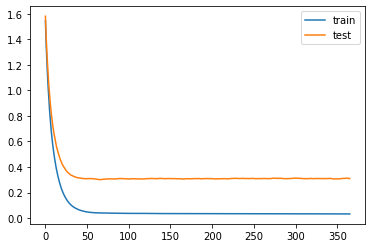

In [ ]:
import xgboost as xgb
print(X_test_features.shape, X_for_training.shape, y_train.shape, y_test.shape)
evalset = [(X_for_training, y_train), (X_test_features,y_test)]
from sklearn.metrics import accuracy_score
model = xgb.XGBClassifier(n_estimators=2000, eta=0.09,subsample=0.08, colsample_bytree=0.12)
import time
start_time = time.time()
model.fit(X_for_training, y_train, early_stopping_rounds=300,eval_metric='mlogloss', eval_set=evalset)
print("--- %s seconds ---" % (time.time() - start_time))
import pickle
pickle.dump(model, open("./drive/MyDrive/xgb_modelinceptionv200.pkl", "wb"))
yhat = model.predict(X_test_features)
score = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % score)
results = model.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.legend()
plt.show()

In [ ]:
yhat=model.predict(X_test_features)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       120
           1       0.93      0.95      0.94       150
           2       0.97      0.93      0.95       123
           3       0.94      0.90      0.92       185
           4       0.93      0.92      0.92       168
           5       0.12      0.44      0.20         9

    accuracy                           0.91       755
   macro avg       0.81      0.84      0.81       755
weighted avg       0.94      0.91      0.93       755

